<a href="https://colab.research.google.com/github/Gabor132/QuarantineSportsClassifier/blob/master/src/QuarantineSportsConvModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quarantine Sports Classifier 

In [0]:
#
# KERAS2ONNX installation
#
# !pip install -U git+https://github.com/microsoft/onnxconverter-common
# !pip install -U git+https://github.com/onnx/keras-onnx

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import os
os.environ['TF_KERAS'] = '1'
import keras2onnx
from os import listdir
from os.path import isfile, join

IN_COLAB = False
try:
    import google.colab

    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running on local machine")

print("Using tensorflow version {}".format(tf.__version__))
print("Using keras2onnx version {}. Make sure it is 1.7.0".format(keras2onnx.__version__))

## Constants

In [0]:
learning_rate = 0.001
testing_data_percentage = 0.2
nr_of_frames_per_sequence = 15
nr_of_keypoints = 25
nr_of_values_per_keypoint = 3
batch_size = 128
use_frame_differences = False
categories = [0,1,2,3]

# Dataset paths
DRAGOS_COLAB_DATASET_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Dataset/OpenPoseDataset/"
LOCAL_DATASET_PATH = "../datasets/"

# Model paths
DRAGOS_COLAB_MODEL_PATH = "/content/drive/My Drive/QuarantineSportsDatasets/Model/"
LOCAL_MODEL_PATH = "../"

current_dataset_path = DRAGOS_COLAB_DATASET_PATH if IN_COLAB else LOCAL_DATASET_PATH
current_model_path = DRAGOS_COLAB_MODEL_PATH if IN_COLAB else LOCAL_MODEL_PATH

# Get all file names
all_files_names = [f for f in listdir(current_dataset_path) if isfile(join(current_dataset_path, f)) and f.endswith('.json')]
print("Following dataset files have been found: {}".format(all_files_names))

In [0]:
dataset_paths = []
for path in all_files_names:
  dataset_path = current_dataset_path + path
  dataset_paths.append(dataset_path)

print("All files found: {}".format(dataset_paths))

## Load Datasets and create X and Y

## Important to know

1.   Out of open pose we extract for all frames all the 25 keypoints (each keypoint contains the X, Y and score)
2.   The Category exists per frame and are 0 (nothing), 1 (middle pushup), 2 (high pushup) and 3 (low pushup)


In [0]:
# Check if there are any frames with no keypoints
empty_frame_example = np.zeros((25, 3))
def delete_empty_frames(x, y, category, file_path):
    empty_frame_indexes = []
    for index, x_value in enumerate(x):
        if np.array_equal(x_value, empty_frame_example):
            empty_frame_indexes.append(index)
    print("File {} category {} has {} empty frames to delete".format(file_path, category, len(empty_frame_indexes)))
    x = np.delete(x, empty_frame_indexes, axis=0)
    y = np.delete(y, empty_frame_indexes, axis=0)
    return x, y

In [0]:
# Function to calculate the differences from frame to frame and return them as datasets
def get_as_frame_validation(file_x, file_y):
  if use_frame_differences:
    #
    # Having keypoints: (x1, y1, s1) and (x2, y2, s2) => (x2-x1, y2-y1, s2)
    #
    file_x[1:, :, 0] = file_x[1:,:,0] - file_x[0:-1,:,0]
    file_x[1:, :, 1] = file_x[1:,:,1] - file_x[0:-1,:,1]
    # Normalize
    file_x[:, :, 0] = file_x[:, :, 0] / np.max(np.abs(file_x[:, :, 0]))
    file_x[:, :, 1] = file_x[:, :, 1] / np.max(np.abs(file_x[:, :, 1]))
    file_x = file_x[1:]
    file_y = file_y[1:]

# Function to split given dataset into training/validation/testing datasets
def split_dataset_categories(x, category, file_path):
    x_train = []
    x_test = []
    x_validate = []
    y_train = []
    y_test = []
    y_validate = []
    y = to_categorical(np.ones((x.shape[0], 1)) * category, 4)
    if x is None or len(x) == 0:
      print("{} has no frames of category {}".format(file_path, category))
    else:
      x, y = delete_empty_frames(x, y, category, file_path)
      aux_x_train, x_test, aux_y_train, y_test = train_test_split(x, y, test_size=testing_data_percentage)
      x_train, x_validate, y_train, y_validate = train_test_split(aux_x_train, aux_y_train, test_size=testing_data_percentage)
      print("{} has {} frames of category {} ({}/{}/{})".format(file_path, len(x), category, len(x_train), len(x_test), len(x_validate)))
    return [x_train, x_test, x_validate, y_train, y_test, y_validate]

# Function to split dataset per categories
def split_in_categories(dataset_x, dataset_y, categories, file_path):
  data_by_category = []
  for category in categories:
    # Get Indexes
    y_category_indexes = np.where(dataset_y == category)
    # Get Values
    x_category = dataset_x[y_category_indexes]
    sets = split_dataset_categories(x_category, category, file_path)
    data_by_category.append(sets)
  return data_by_category

In [0]:
per_file_datasets = []
for (index, path) in enumerate(dataset_paths):
  df = pd.read_json(path)
  keypoints = df['Keypoints'].values
  file_y = df['Category'].values
  file_x = []
  for k in keypoints:
      if k != None:
          newK = np.reshape(np.asarray(k), (25,3))
          file_x.append(newK)
      else:
          file_x.append(np.reshape(np.zeros(75), (25,3)))
  file_x = np.array(file_x)
  split_by_categories = split_in_categories(file_x, file_y, categories, path)
  per_file_datasets.append(split_by_categories)

In [0]:
x_train = None
x_test = None
x_validate = None
y_train = None
y_test = None
y_validate = None

# Merge all over train/test/validation sets

for category in categories:
  for dataset in per_file_datasets:
    sets = dataset[category]
    if x_train is None:
      x_train = np.asarray(sets[0])
      x_test = np.asarray(sets[1])
      x_validate = np.asarray(sets[2])
      y_train = np.asarray(sets[3])
      y_test = np.asarray(sets[4])
      y_validate = np.asarray(sets[5])
    else:
      if(len(sets[0]) > 0):
        x_train = np.vstack((x_train, np.asarray(sets[0])))
      if(len(sets[1]) > 0):
        x_test = np.vstack((x_test,np.asarray(sets[1])))
      if(len(sets[2]) > 0):
        x_validate = np.vstack((x_validate,np.asarray(sets[2])))
      if(len(sets[3]) > 0):
        y_train = np.vstack((y_train,np.asarray(sets[3])))
      if(len(sets[4]) > 0):
        y_test = np.vstack((y_test,np.asarray(sets[4])))
      if(len(sets[5]) > 0):
        y_validate = np.vstack((y_validate,np.asarray(sets[5])))

print("Training set {}/ Testing set {}/ Validation set {}".format(len(y_train), len(y_test), len(y_validate)))

# Rearrange to fit Model

In [0]:
def rearange_x_dataset(datasets):
  new_datasets = []
  for data in datasets:
      # switch 3 and 4th axes to have as features the keypoints
      new_datasets.append(np.reshape(data, newshape=(data.shape[0], 25, 3, 1)))
  return new_datasets

dataset = rearange_x_dataset([x_train, x_validate, x_test])
aux_x_train = dataset[0]
aux_x_validation = dataset[1]
aux_x_test = dataset[2]
aux_y_train =  np.squeeze(y_train)
aux_y_validation = np.squeeze(y_validate)
aux_y_test = np.squeeze(y_test)

## Defining the Model

In [0]:
# Callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [0]:
def conv_model():
  model = tf.keras.Sequential(layers=[
                                    tf.keras.Input(shape=(25, 3, 1), name="INPUT"),
                                    tf.keras.layers.Conv2D(15, kernel_size=(5, 1), name="CONV_1"),
                                    tf.keras.layers.AveragePooling2D((2, 1), name="MAXPOOL_1"),
                                    tf.keras.layers.ReLU(name="RELU_1"),
                                    tf.keras.layers.Conv2D(75, kernel_size=(8, 2), name="CONV_2"),
                                    tf.keras.layers.MaxPooling2D((1, 2), name="MAXPOOL_2"),
                                    tf.keras.layers.ReLU(name="RELU_2"),
                                    tf.keras.layers.Flatten(name="FLATTEN"),
                                    tf.keras.layers.Dense(categories.shape[0], name="FULLY_CONNECTED"),
                                    tf.keras.layers.Softmax(1, name="OUTPUT_SOFTMAX")
                                    ], name="QuarantineSportsCONV")
  return model

In [0]:
def best_conv_model():
  input_tensor = tf.keras.backend.placeholder((None,25,3,1), dtype=tf.float32)
  model = tf.keras.Sequential(layers=[
                                    tf.keras.Input(shape=(-1, 25, 3, 1), name="INPUT", tensor=input_tensor, sparse=True),
                                    tf.keras.layers.Conv2D(50, kernel_size=(18, 2), name="CONV_1", data_format="channels_last", activation="relu"),
                                    tf.keras.layers.Dropout(0.3, name="DROPOUT_1"),
                                    tf.keras.layers.Conv2D(75, kernel_size=(8, 2), name="CONV_2", data_format='channels_last', activation="relu"),
                                    tf.keras.layers.Flatten(name="FLATTEN", data_format='channels_last'),
                                    tf.keras.layers.Dense(len(categories), name="FULLY_CONNECTED"),
                                    tf.keras.layers.Softmax(1, name="OUTPUT_SOFTMAX")
                                    ], name="QuarantineSportsCONV")
  return model

In [0]:
model = best_conv_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_crossentropy])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training Model

In [0]:
# Training
print("\n# Training")
history = model.fit(aux_x_train, aux_y_train, epochs=30, batch_size=batch_size, validation_data=(aux_x_validation, aux_y_validation), validation_batch_size=batch_size,
                    callbacks=[callback], verbose=1)
print('\n# Evaluate')
result = model.evaluate(aux_x_test, aux_y_test, batch_size=batch_size, verbose=1)

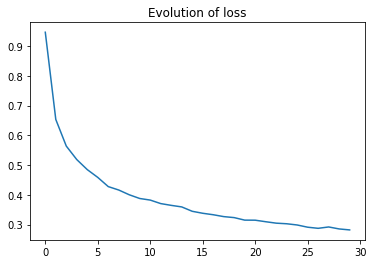

In [508]:
plt.plot(history.history['loss'])
plt.title("Evolution of loss")
plt.show()

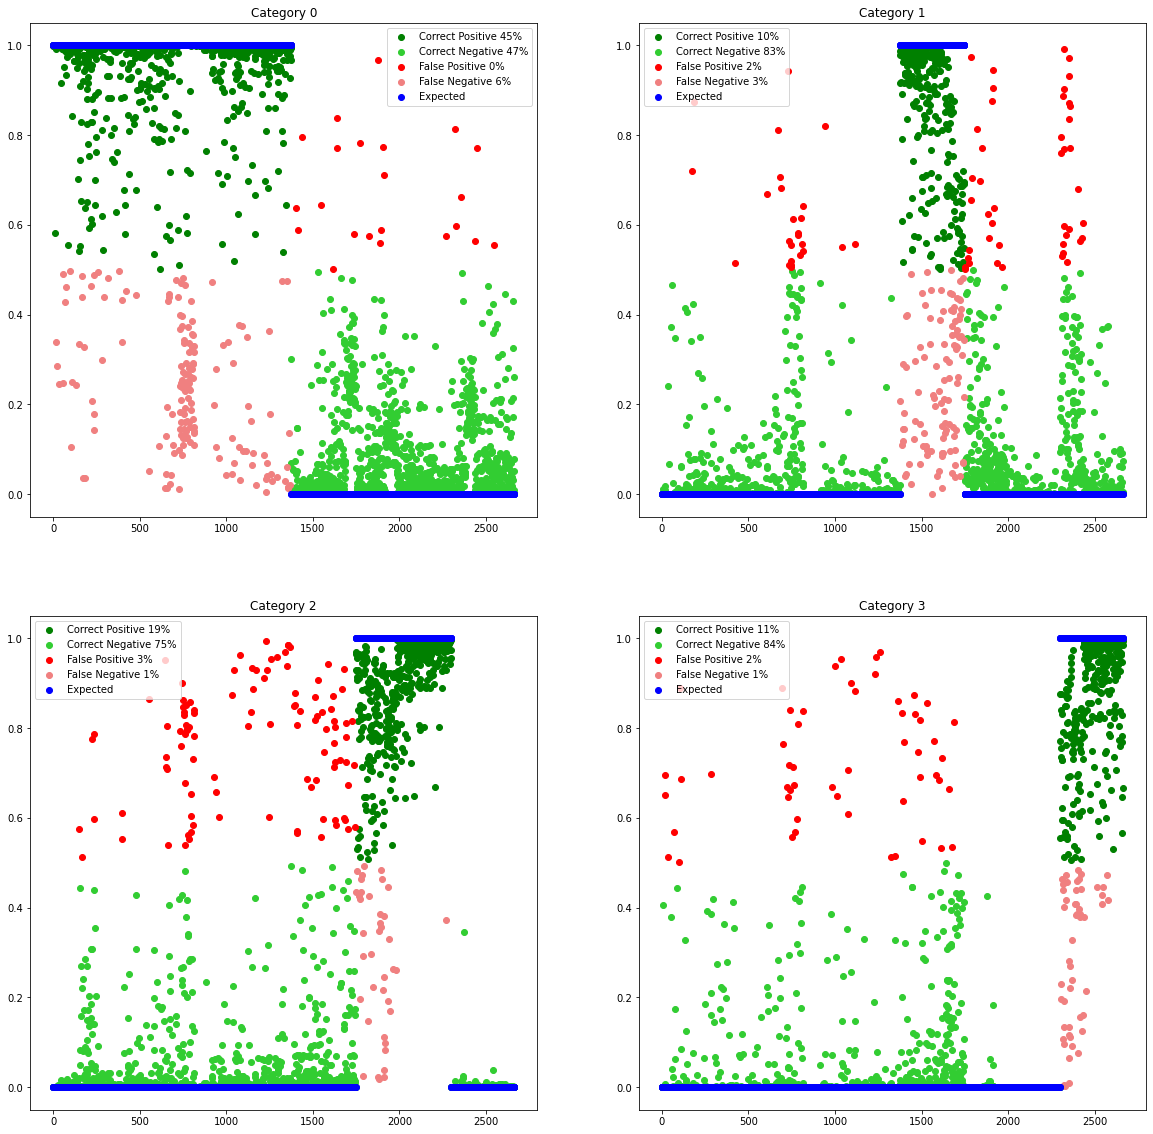

In [509]:
results = model.predict(aux_x_test)

plt.figure(0, figsize=(20, 20))
for i in categories:
  result = results[:, i]
  plt.subplot(2, 2, i+1)
  all_index = range(len(result))
  correct_positive = np.where(result >= 0.5)[0]
  correct_positive = np.intersect1d(correct_positive, np.where(y_test[:, i] == 1)[0])
  correct_negative = np.where(result < 0.5)[0]
  correct_negative = np.intersect1d(correct_negative, np.where(y_test[:, i] != 1)[0])
  false_positive = np.where(result >= 0.5)[0]
  false_positive = np.intersect1d(false_positive, np.where(y_test[:, i] != 1)[0])
  false_negative = np.where(result < 0.5)[0]
  false_negative = np.intersect1d(false_negative, np.where(y_test[:, i] == 1)[0])
  plt.scatter(correct_positive, results[:,i][correct_positive], c='g')
  plt.scatter(correct_negative, results[:,i][correct_negative], c='limegreen')
  plt.scatter(false_positive, results[:,i][false_positive], c='r')
  plt.scatter(false_negative, results[:,i][false_negative], c='lightcoral')
  plt.scatter(range(len(result)), y_test[:, i], c='b')
  plt.legend(["Correct Positive {}%".format(int(len(correct_positive)/len(result) * 100)),
              "Correct Negative {}%".format(int(len(correct_negative)/len(result) * 100)),
              "False Positive {}%".format(int(len(false_positive)/len(result) * 100)),
              "False Negative {}%".format(int(len(false_negative)/len(result) * 100)),
              "Expected"])
  plt.title("Category " + str(i))
plt.show()

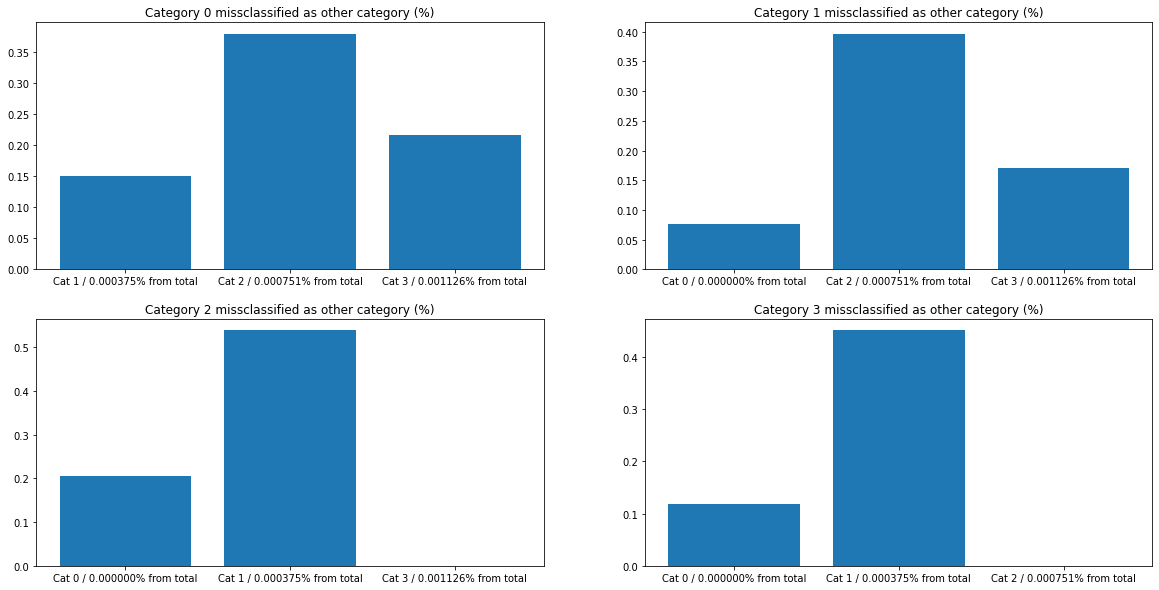

In [510]:
#
# For each category, what percentage of frames get missclassfied and to which other class
# This could help us understand if there are issues in the annotation of our data (similar frames are annotated as different classes)
#
plt.figure(3, figsize=(20, 10))
for i in categories:
  # Take all our probability for category i
  result = results[:, i]
  plt.subplot(2, 2, i+1)
  all_index = range(len(result))
  # Get the indexes where the probability is less then 0.5
  false_negative = np.where(result < 0.5)[0]
  # Intersect it with the indexes where the result should be our category i
  false_negative = np.intersect1d(false_negative, np.where(y_test[:, i] == 1)[0])
  false_negatives_per_category = []
  for j in categories:
    if i == j:
      continue
    # Intersect our false negative indexes with the indexes where another category (j) has the biggest probability
    false_negative_categ_j = np.intersect1d(false_negative, np.where(results[:, j] >= 0.5))
    false_negatives_per_category.append(len(false_negative_categ_j)/len(false_negative))
  plt.bar(["Cat {} / {:f}% from total".format(j, j / len(results[:, i] * 100)) for j in np.setdiff1d(range(4), [i])], false_negatives_per_category)
  plt.title("Category {} missclassified as other category (%)".format(str(i)))
plt.show()

Total tested 2664


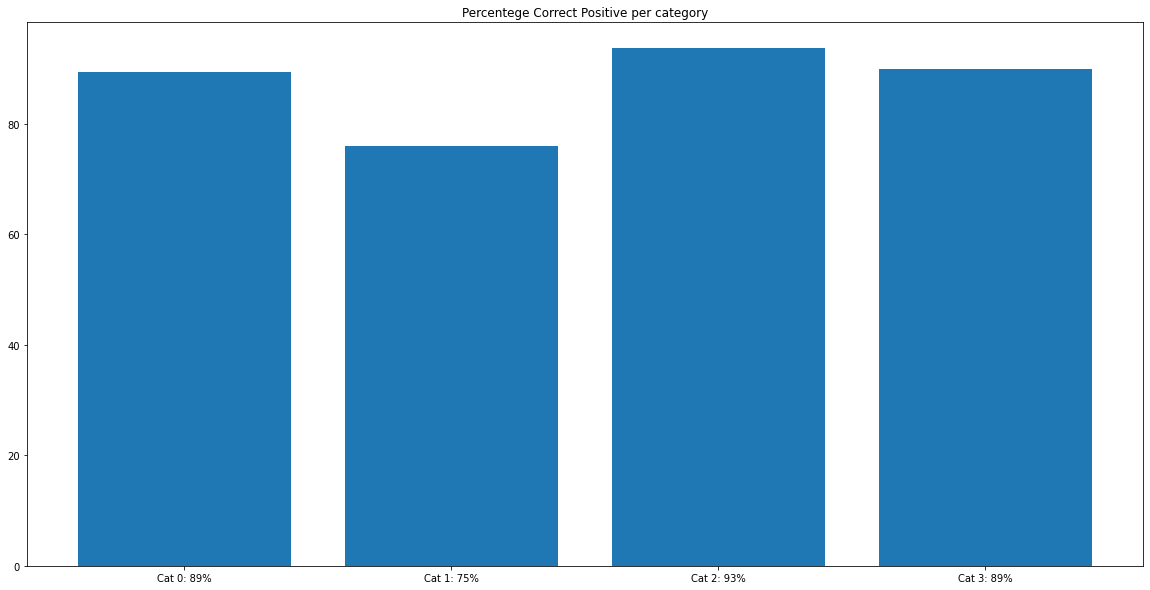

In [511]:
predict = model.predict(aux_x_test)
nr_correct = np.zeros(4)
nr_wrong = np.zeros(4)
for (index, p) in enumerate(predict):
  p_category = np.where(p == np.max(p))[0][0]
  e_category = np.where(y_test[index] == np.max(y_test[index]))[0][0]
  if p_category == e_category:
    nr_correct[e_category] = nr_correct[e_category]+ 1
  else:
    nr_wrong[e_category] = nr_wrong[e_category] + 1
print("Total tested {}".format(len(predict)))
plt.figure(1, figsize=(20, 10))
plt.bar(["Cat " + str(j) + ": " + str(int(nr_correct[j] / (nr_correct[j] + nr_wrong[j])* 100)) + "%" for j in range(4)], nr_correct / (nr_correct + nr_wrong) * 100)
plt.title("Percentege Correct Positive per category")
plt.show()


## Saving Model to JSON

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(current_model_path + "Conv/model_conv.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(current_model_path + "model_conv.h5")
print("Saved model to disk")

# Convert Model to ONNX

In [0]:
onnx_model = keras2onnx.convert_keras(model)
keras2onnx.save_model(onnx_model, current_model_path + "Conv/conv.onnx")

# Finish